<a href="https://colab.research.google.com/github/sivask01/CMPE-255-01/blob/CNN/255_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Data Loading**

Mounted at /content/drive
Images from CMFD (Correctly Masked Face Dataset):


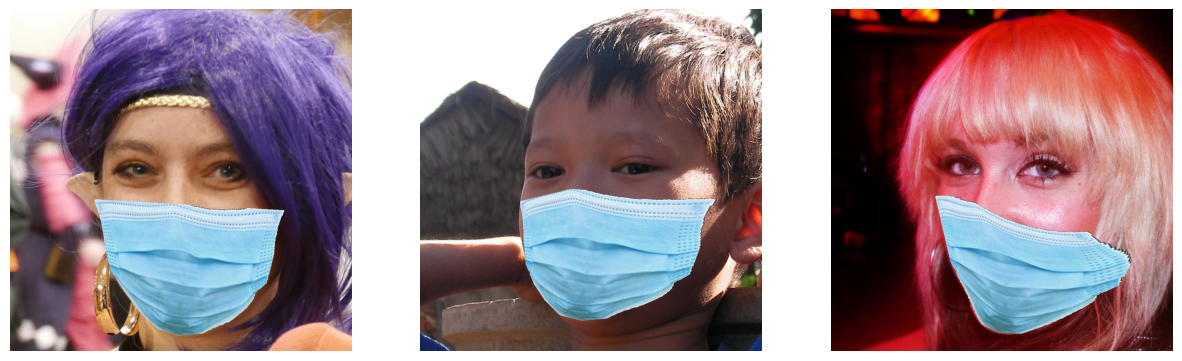

Images from IMFD (Incorrectly Masked Face Dataset):


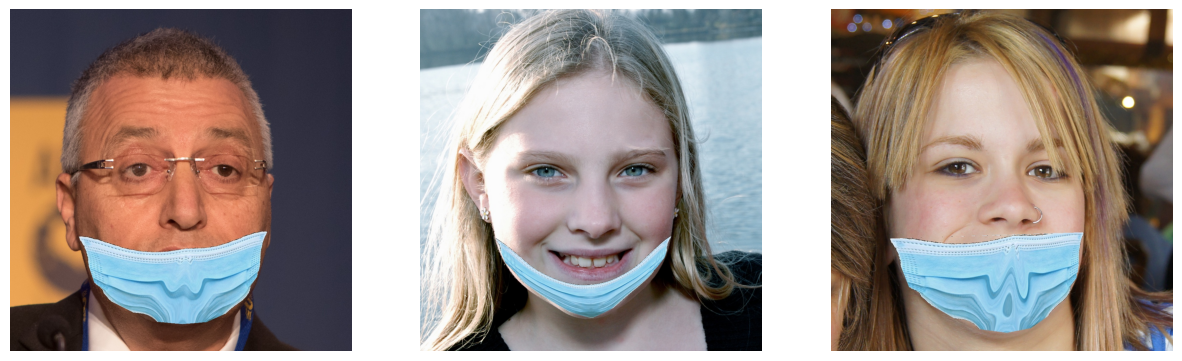

Images from No Mask:


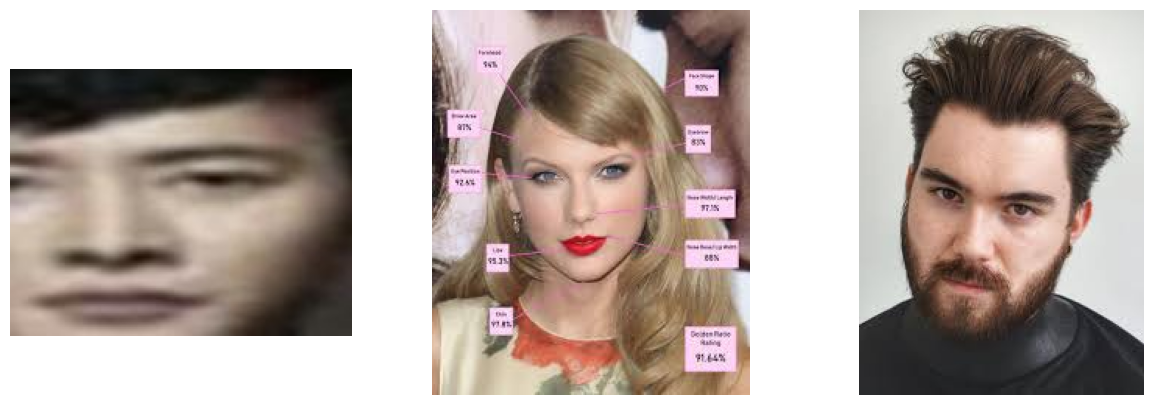

In [1]:
from google.colab import drive
drive.mount('/content/drive')
# Path to your dataset
dataset_path = '/content/drive/MyDrive/Colab Notebooks/255_Project/Classes/'
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Function to display images
def display_images(folder_path, num_images=3):
    image_files = os.listdir(folder_path)[:num_images]
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for ax, image_file in zip(axes, image_files):
        image_path = os.path.join(folder_path, image_file)
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

# Displaying images from each category
print("Images from CMFD (Correctly Masked Face Dataset):")
display_images(f"{dataset_path}/CMFD")

print("Images from IMFD (Incorrectly Masked Face Dataset):")
display_images(f"{dataset_path}/IMFD")

print("Images from No Mask:")
display_images(f"{dataset_path}/NO_MASK")

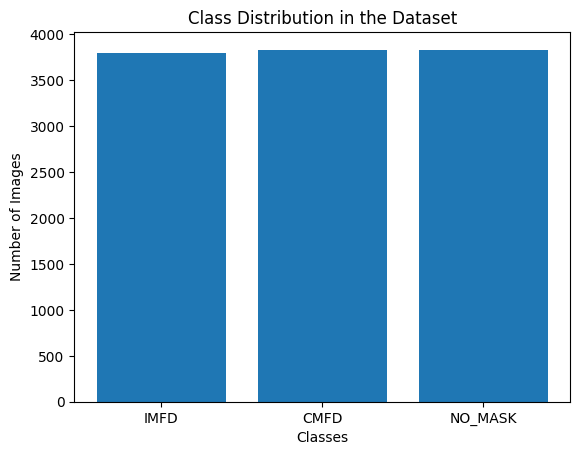

In [2]:
# Count images in each class
class_distribution = {folder: len(os.listdir(os.path.join(dataset_path, folder)))
                      for folder in os.listdir(dataset_path)}

# Plotting the class distribution
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution in the Dataset')
plt.show()

#**Data Preprocessing & Augmentation**

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (64, 64)
batch_size = 16

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    directory=dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    directory=dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 9169 images belonging to 3 classes.
Found 2291 images belonging to 3 classes.


#**Build & Train the model**

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

##Avoid Overfitting

In [5]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
573/573 [==============================] - 2143s 4s/step - loss: 0.6033 - accuracy: 0.7476 - val_loss: 0.4298 - val_accuracy: 0.8405
Epoch 2/10
573/573 [==============================] - 217s 378ms/step - loss: 0.3835 - accuracy: 0.8692 - val_loss: 0.3362 - val_accuracy: 0.8885
Epoch 3/10
573/573 [==============================] - 197s 345ms/step - loss: 0.3168 - accuracy: 0.9089 - val_loss: 0.2218 - val_accuracy: 0.9436
Epoch 4/10
573/573 [==============================] - 195s 341ms/step - loss: 0.2511 - accuracy: 0.9348 - val_loss: 0.2236 - val_accuracy: 0.9462
Epoch 5/10
573/573 [==============================] - 216s 376ms/step - loss: 0.2466 - accuracy: 0.9390 - val_loss: 0.1876 - val_accuracy: 0.9620
Epoch 6/10
573/573 [==============================] - 196s 342ms/step - loss: 0.2159 - accuracy: 0.9487 - val_loss: 0.1640 - val_accuracy: 0.9642
Epoch 7/10
573/573 [==============================] - 190s 331ms/step - loss: 0.1950 - accuracy: 0.9568 - val_loss: 0.1491 - v

#**Visualizing Training Results**

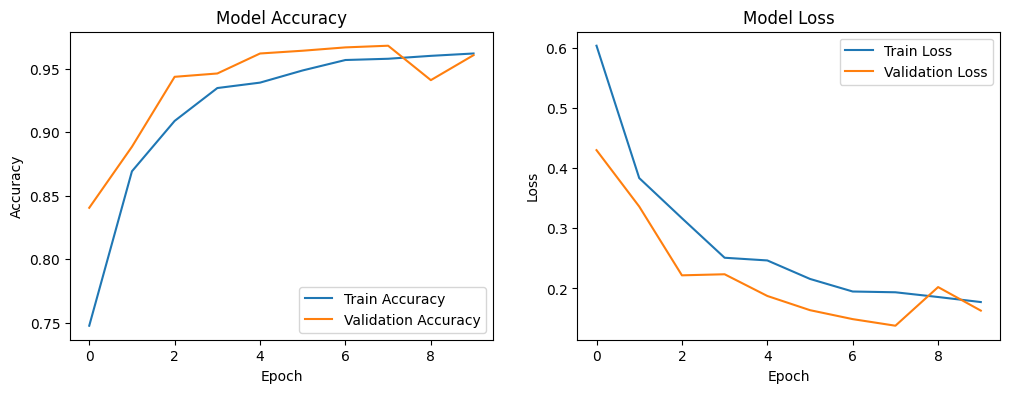

In [6]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

In [10]:
model.save('255_CNN_Model.h5')  # Saves the model to a HDF5 file

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#**Load and Test the Model**

In [11]:
from tensorflow.keras.models import load_model

# Load the model
cnn_model = load_model('255_CNN_Model.h5')

In [15]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def predict_image(image_path, model):
    img = load_img(image_path, target_size=(64, 64))
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)
    return np.argmax(prediction, axis=1)

test_folder_path = '/content/drive/MyDrive/Colab Notebooks/255_Project/Test_Classes/'
test_images = [os.path.join(test_folder_path, file) for file in os.listdir(test_folder_path) if file.endswith('.jpg')]

for image_path in test_images:
    predicted_index = predict_image(image_path, cnn_model)[0]
    class_prediction = ['CMFD', 'IMFD', 'No Mask'][predicted_index]
    print(f"Image: {os.path.basename(image_path)}, Prediction: {class_prediction}")

1/1 [==============================] - 0s 34ms/step
Image: 37002_Mask.jpg, Prediction: CMFD
1/1 [==============================] - 0s 32ms/step
Image: 37003_Mask.jpg, Prediction: CMFD
1/1 [==============================] - 0s 39ms/step
Image: 37001_Mask.jpg, Prediction: CMFD
1/1 [==============================] - 0s 37ms/step
Image: mixed.jpg, Prediction: No Mask
1/1 [==============================] - 0s 35ms/step
Image: no_mask.jpg, Prediction: No Mask
1/1 [==============================] - 0s 29ms/step
Image: no_mask2.jpg, Prediction: No Mask
1/1 [==============================] - 0s 23ms/step
Image: partial_mask4.jpg, Prediction: IMFD
1/1 [==============================] - 0s 22ms/step
Image: partial_mask3.jpg, Prediction: IMFD
1/1 [==============================] - 0s 23ms/step
Image: partial_mask5.jpg, Prediction: IMFD
1/1 [==============================] - 0s 22ms/step
Image: partial_mask2.jpg, Prediction: IMFD
1/1 [==============================] - 0s 22ms/step
Image: partial_ma

#**Confusion Matrix**

1/1 [==============================] - 0s 25ms/step


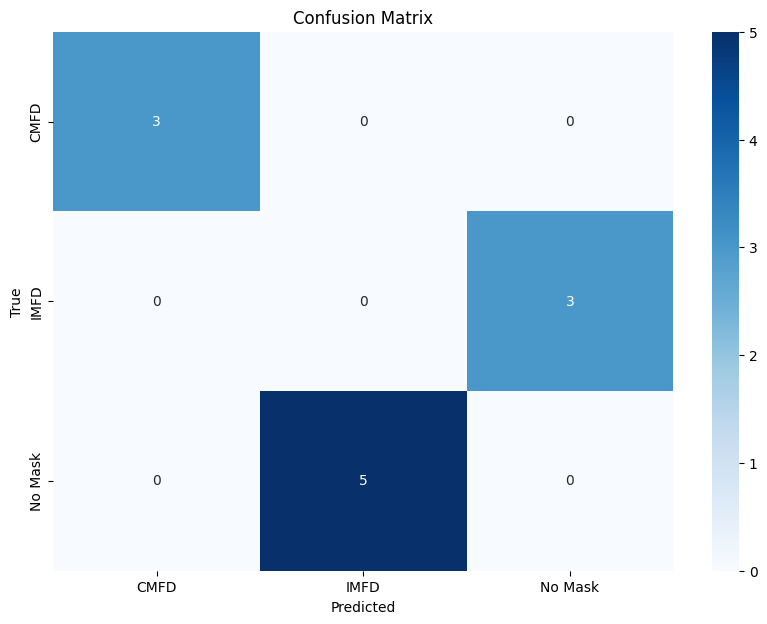

              precision    recall  f1-score   support

        CMFD       1.00      1.00      1.00         3
        IMFD       0.00      0.00      0.00         3
     No Mask       0.00      0.00      0.00         5

    accuracy                           0.27        11
   macro avg       0.33      0.33      0.33        11
weighted avg       0.27      0.27      0.27        11



In [16]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Function to preprocess the image
def preprocess_image(image_path, target_size=(64, 64)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0
    return np.expand_dims(img_array, axis=0)

# Path to the test images folder
test_folder_path = '/content/drive/MyDrive/Colab Notebooks/255_Project/Test_Classes'
test_image_paths = [os.path.join(test_folder_path, f) for f in os.listdir(test_folder_path) if f.endswith('.jpg')]

# Predicting each image
predictions = []
for img_path in test_image_paths:
    processed_img = preprocess_image(img_path)
    prediction = model.predict(processed_img)
    predicted_class = np.argmax(prediction, axis=1)
    predictions.extend(predicted_class)

# True labels (you need to provide this based on your knowledge of the data)
true_labels = [0,0,0,1,1,1,2,2,2,2,2]  # Replace with the actual labels, like [0, 0, 1, 2, ...]

# Generating the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=['CMFD', 'IMFD', 'No Mask'],
            yticklabels=['CMFD', 'IMFD', 'No Mask'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(true_labels, predictions, target_names=['CMFD', 'IMFD', 'No Mask'], zero_division=0))